In [1]:
import tensorflow as tf

In [2]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, channel, compress):
        super().__init__()
        self.channel = channel
        self.compress = compress

        self.identity = tf.keras.layers.Conv2D(filters=channel, kernel_size=1)

        self.dense = tf.keras.layers.Conv2D(filters=channel//compress, kernel_size=1)
        self.kernel_3 = tf.keras.layers.Conv2D(filters=channel, kernel_size=3, activation='relu', padding='same')
        self.kernel_5 = tf.keras.layers.Conv2D(filters=channel, kernel_size=5, activation='relu', padding='same')
        self.kernel_7 = tf.keras.layers.Conv2D(filters=channel, kernel_size=7, activation='relu', padding='same')
        self.kernel_11 = tf.keras.layers.Conv2D(filters=channel, kernel_size=11, activation='relu', padding='same')

        self.outdense = tf.keras.layers.Conv2D(filters=channel, kernel_size=1, activation='relu')
    
    @tf.function
    def call(self, inp):
        x = self.dense(inp)
        x = tf.concat([self.kernel_3(x), self.kernel_5(x), self.kernel_7(x), self.kernel_11(x)], axis=-1)
        x = self.outdense(x)
        x = x + self.identity(inp)
        return x
    
    def get_config(self):
        return dict(channel = self.channel, compress = self.compress, name = self.name)

class DenseSequential(tf.keras.layers.Layer):
    #參考自DenseNet
    #參考文章https://zhuanlan.zhihu.com/p/37189203
    def __init__(self, all_layers):
        super().__init__()
        self.all_layers = all_layers
    
    @tf.function
    def call(self, inp):
        for layer in self.all_layers:
            x = layer(inp)
            inp = tf.concat([inp, x], axis=-1)
        return inp
    
    def get_config(self):
        return dict(name = self.name)

class Model(tf.keras.Model):
    def __init__(self,):
        super(__class__, self).__init__()
        self.preprocess = tf.keras.layers.Rescaling(1/255)

        self.encoder = DenseSequential([
            tf.keras.layers.Rescaling(1/255),
            ConvBlock(4, 1),
            ConvBlock(8, 2),
            ConvBlock(16, 4),
            ConvBlock(32, 8),
            ConvBlock(64, 16)
        ])

        self.decoder = DenseSequential([
            ConvBlock(32, 8),
            ConvBlock(16, 4),
            ConvBlock(8, 2)
        ])

        self.final = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=64, kernel_size=1, activation='relu'),
            tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation='sigmoid')
        ])

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8)])
    def call(self, rgb):
        x = self.preprocess(rgb)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.final(x)
        pred = tf.squeeze(x,axis=-1)
        return pred
    
    @tf.function(input_signature=(
        (tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(None, None, None), dtype=tf.uint8)),
    ))
    def train_step(self,dataset):
        rgb, gray = dataset
        with tf.GradientTape() as tape:
            pred = self(rgb)
            loss = self.loss(gray, pred)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.mean_loss_metric.update_state(loss)
        return {m.name:m.result() for m in self.metrics}

    def compile(self,loss,optimizer):
        super().compile()
        self.loss = loss
        self.optimizer = optimizer
        self.mean_loss_metric = tf.keras.metrics.Mean(name='train_loss')
        
    @property    
    def metrics(self):
        return [self.mean_loss_metric]
    
    def predict(self,imgs):
        if tf.rank(imgs) == 3:
            imgs = imgs[None,...]
        pred = self(imgs)
        return tf.squeeze(pred,axis=0)
    
    def get_config(self):
        return dict(layers = self.layers, name = self.name)
        
model = Model()

In [3]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(tf.cast(self.d_model, tf.float32)) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return dict(d_model=self.d_model, warmup_steps=self.warmup_steps)
    
learning_rate = CustomSchedule(128)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [4]:
%run env_setup

import data_pipeline
--create_dataset(batch_size)
import loss_functions
--BCE_loss_2D(gray, pred)
import train_process
--train(model,dataset,epochs)
--convert_test_image(model)
--save_model(model,model_name)
--load_model(model_name)


In [5]:
dataset = data_pipeline.create_dataset(batch_size=4)

model.compile(loss_functions.BCE_loss_2D, optimizer)

EPOCH: 0
71/71 [==============================] - 123s 2s/step - train_loss: 0.8613


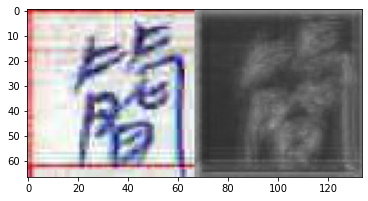

EPOCH: 1
71/71 [==============================] - 17s 248ms/step - train_loss: 0.3974


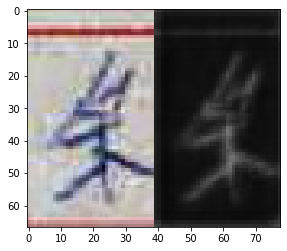

EPOCH: 2
71/71 [==============================] - 14s 192ms/step - train_loss: 0.2783


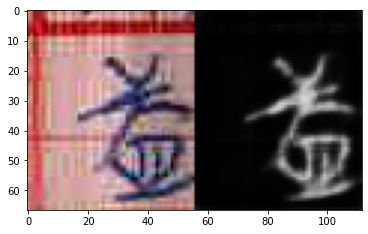

EPOCH: 3
71/71 [==============================] - 11s 155ms/step - train_loss: 0.1391


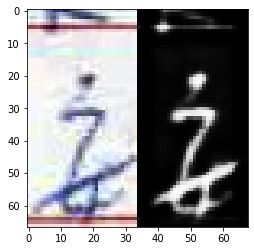

EPOCH: 4
71/71 [==============================] - 9s 127ms/step - train_loss: 0.1121


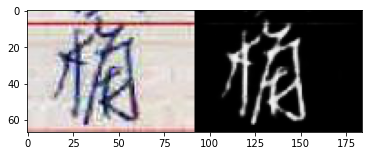

In [6]:
train_process.train(model,dataset,epochs=5)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        multiple                  0         
_________________________________________________________________
dense_sequential (DenseSeque multiple                  130012    
_________________________________________________________________
dense_sequential_1 (DenseSeq multiple                  61476     
_________________________________________________________________
sequential (Sequential)      (None, None, None, 1)     12033     
Total params: 203,523
Trainable params: 203,521
Non-trainable params: 2
_________________________________________________________________


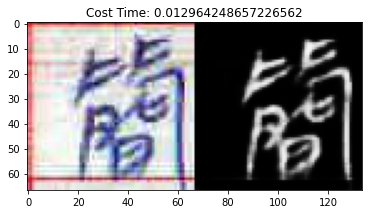

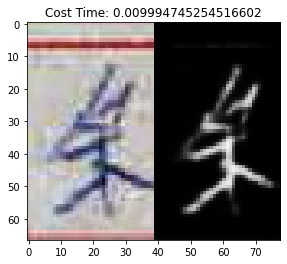

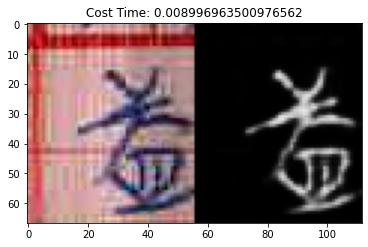

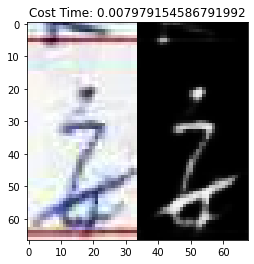

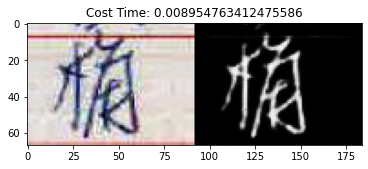

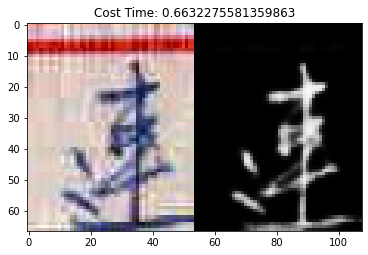

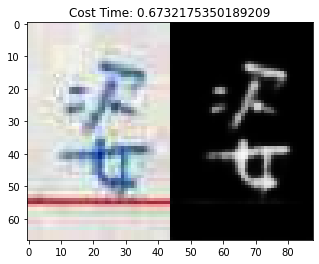

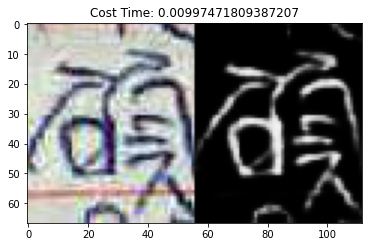

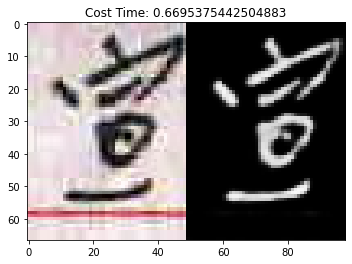

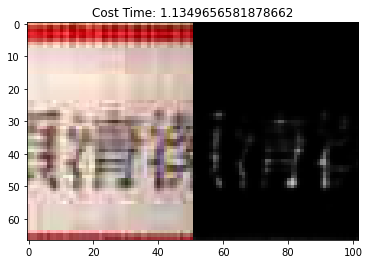

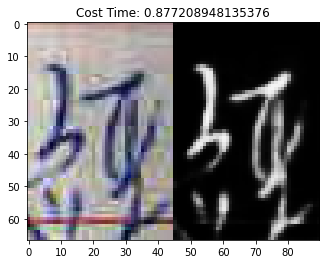

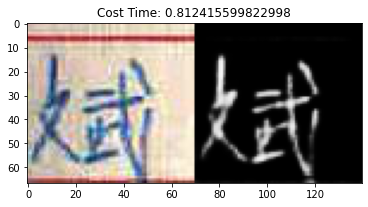

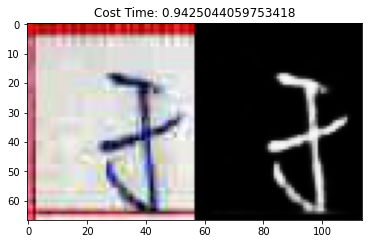

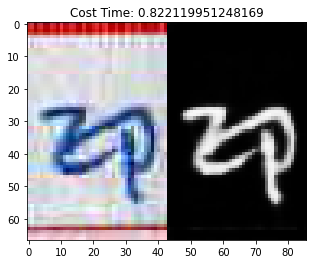

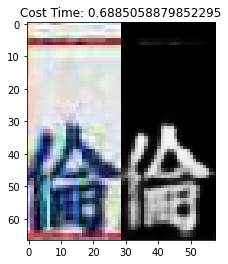

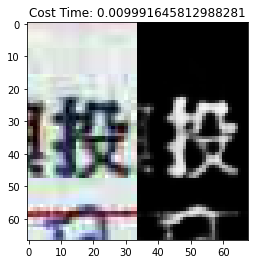

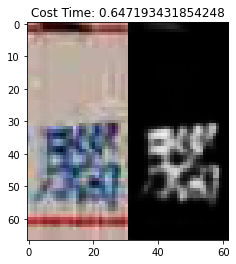

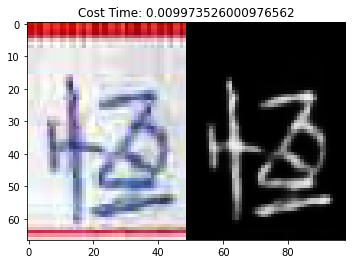

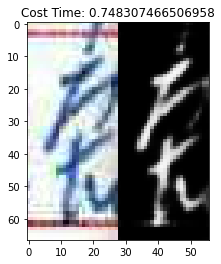

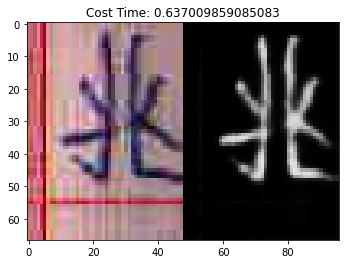

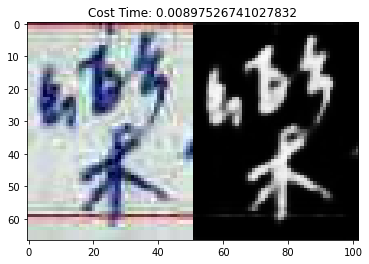

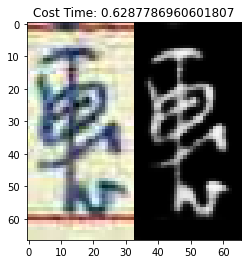

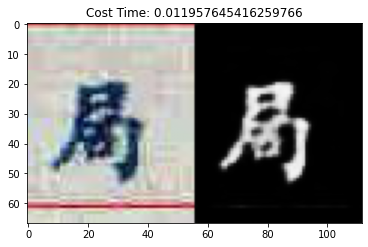

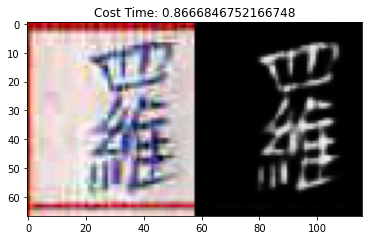

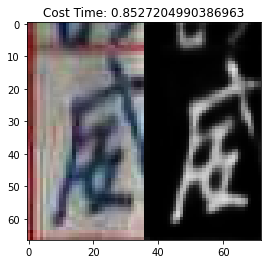

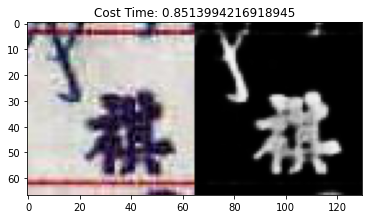

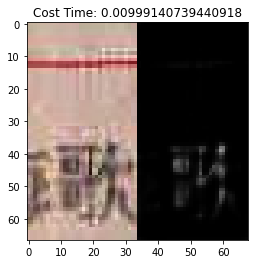

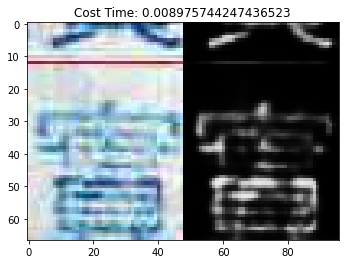

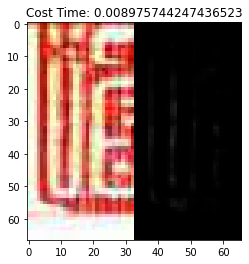

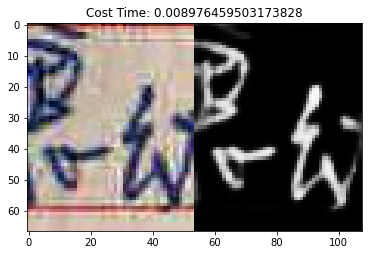

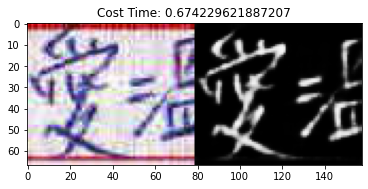

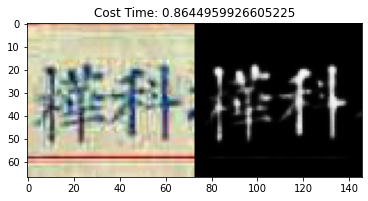

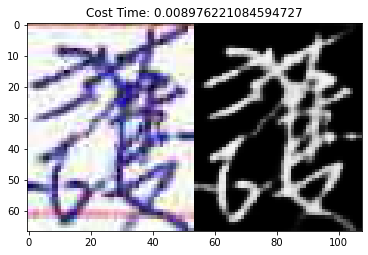

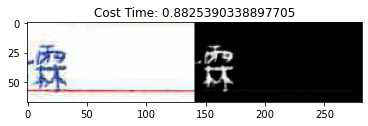

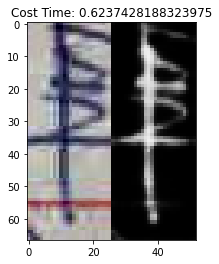

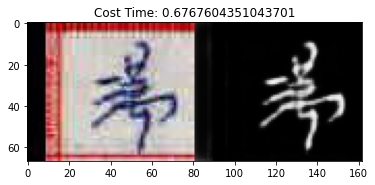

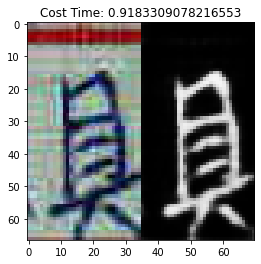

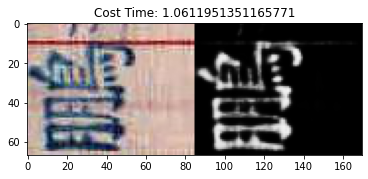

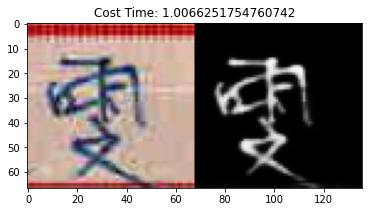

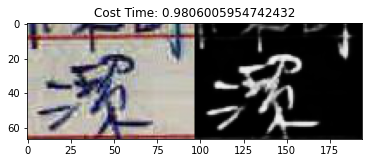

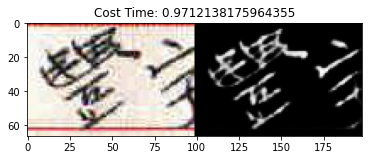

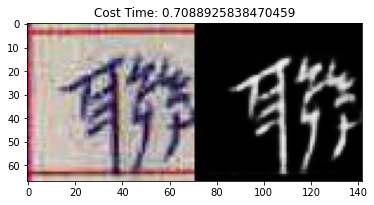

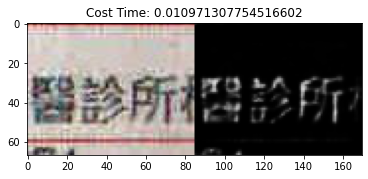

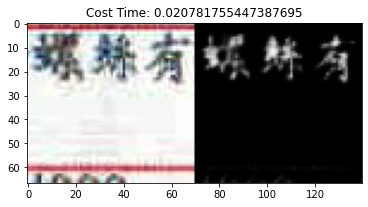

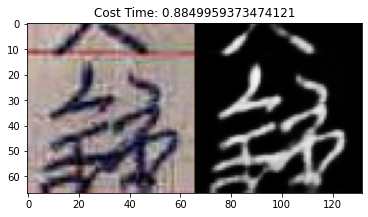

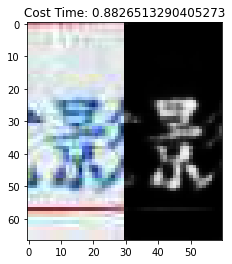

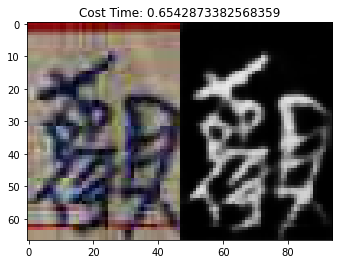

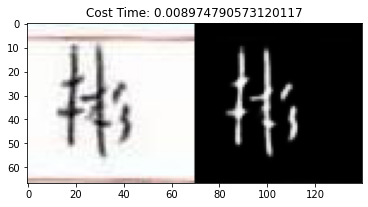

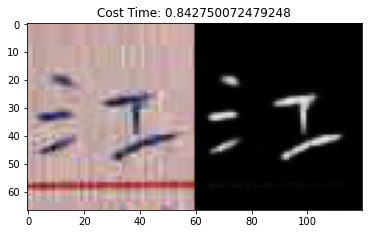

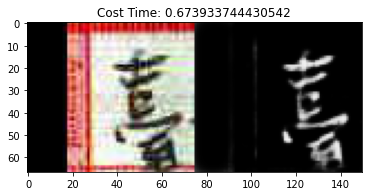

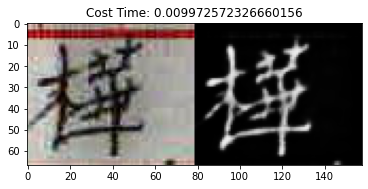

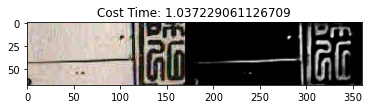

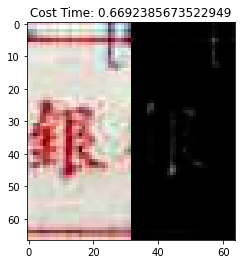

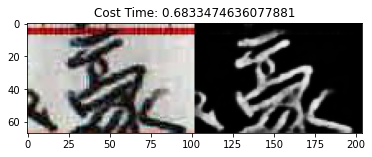

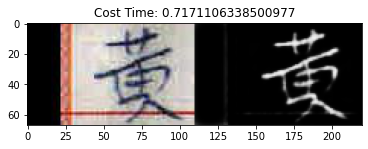

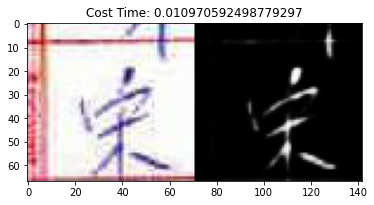

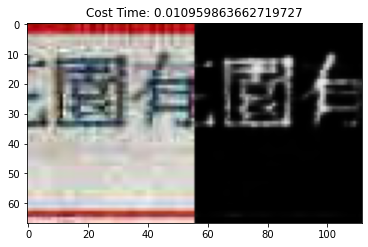

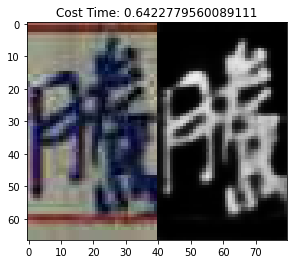

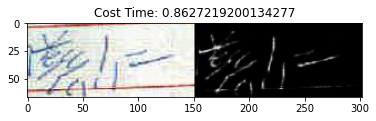

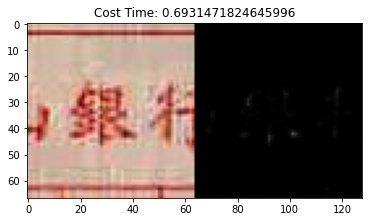

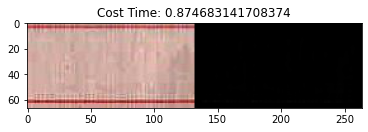

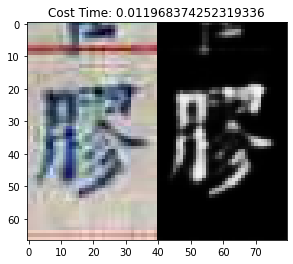

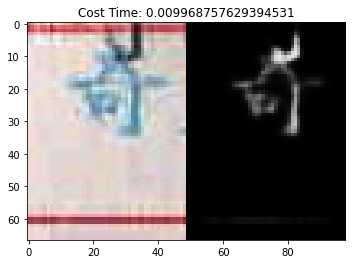

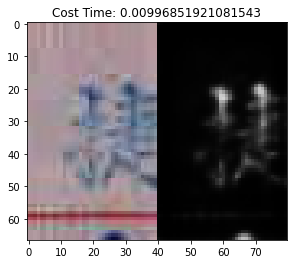

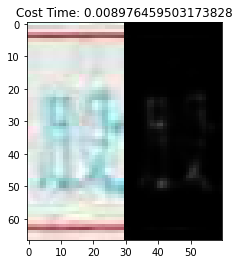

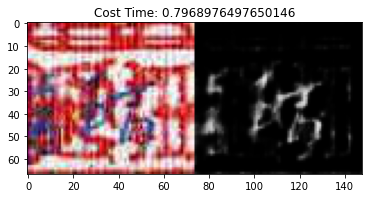

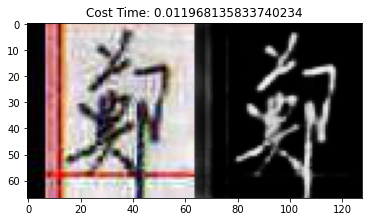

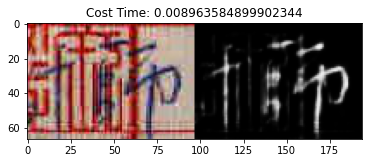

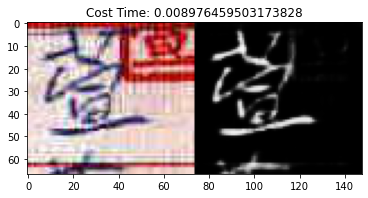

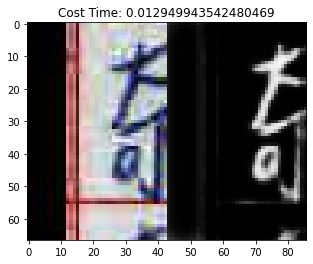

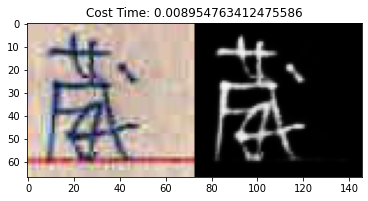

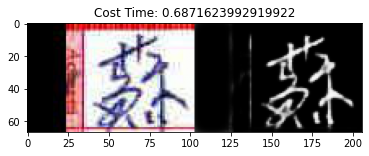

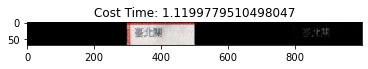

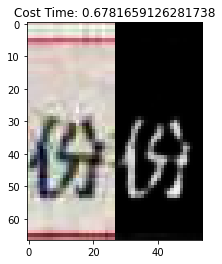

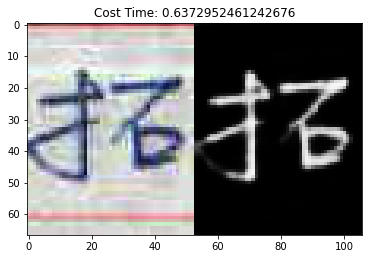

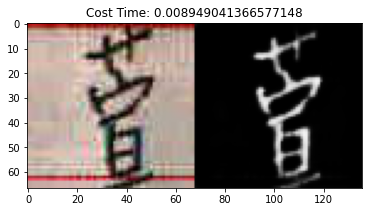

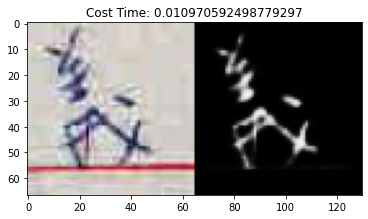

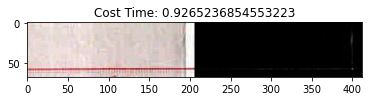

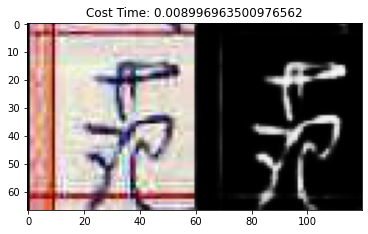

In [8]:
train_process.convert_test_image(model)

In [11]:
train_process.save_model(model,'DenseConv')

INFO:tensorflow:Assets written to: SavedModels/DenseConv\assets


INFO:tensorflow:Assets written to: SavedModels/DenseConv\assets


In [12]:
loaded_model = train_process.load_model('DenseConv')

KeyError: 'name'

In [ ]:
train_process.convert_test_image(loaded_model)